In [4]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip install -q transformers datasets scikit-learn pandas

from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from datasets import Dataset, DatasetDict

# 1. Load dataset
df = pd.read_csv("dataset-tickets-multi-lang-4-20k.csv")

# Fill potential missing values in 'answer' with an empty string
df['answer'] = df['answer'].fillna('')

# 2. Prepare input-output format
def format_example(row):
    input_text = f"question: {row['subject']} context: {row['body']}"
    output_text = row['answer']
    return {"input_text": input_text, "output_text": output_text}

formatted_data = df.apply(format_example, axis=1, result_type="expand")

# 3. Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(formatted_data)

# 4. Train-test split
split_dataset = hf_dataset.train_test_split(test_size=0.1, seed=42)

# 5. Load tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# 6. Tokenize function
def tokenize(example):
    model_inputs = tokenizer(example["input_text"], max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(example["output_text"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = split_dataset.map(tokenize, batched=True)

# 7. Load model
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# 8. Define training arguments
training_args = TrainingArguments(
    output_dir="./t5-support-bot",
    # Changed evaluation_strategy to eval_strategy
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
)

# 9. Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# 10. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# 11. Train the model
trainer.train()

# 12. Save final model
model.save_pretrained("./final-t5-support-bot")
tokenizer.save_pretrained("./final-t5-support-bot")

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

<ipython-input-4-17b7dc0a3108>:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: naserinahid (naserinahid-george-brown-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.322700,1.208877


Epoch,Training Loss,Validation Loss
1,1.322700,1.208877
2,1.259800,1.140851
3,1.253900,1.124465


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


('./final-t5-support-bot/tokenizer_config.json',
 './final-t5-support-bot/special_tokens_map.json',
 './final-t5-support-bot/spiece.model',
 './final-t5-support-bot/added_tokens.json')

In [5]:
import zipfile
import os

# Define the directory where your model and tokenizer are saved
model_directory = "./final-t5-support-bot"

# Define the name for your zip file
zip_filename = "final-t5-support-bot.zip"

# Create a ZipFile object in write mode
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the directory and add each file to the zip
    for root, dirs, files in os.walk(model_directory):
        for file in files:
            # Create the full path to the file
            file_path = os.path.join(root, file)
            # Add the file to the zip archive, maintaining the directory structure
            # The arcname is the path within the zip file
            arcname = os.path.relpath(file_path, model_directory)
            zipf.write(file_path, arcname)

print(f"Model and tokenizer saved to {zip_filename}")

Model and tokenizer saved to final-t5-support-bot.zip


In [3]:
!unzip -o final-t5-support-bot.zip -d ./final-t5-support-bot

Archive:  final-t5-support-bot.zip
  inflating: ./final-t5-support-bot/added_tokens.json  
  inflating: ./final-t5-support-bot/config.json  
  inflating: ./final-t5-support-bot/tokenizer_config.json  
  inflating: ./final-t5-support-bot/spiece.model  
  inflating: ./final-t5-support-bot/generation_config.json  
  inflating: ./final-t5-support-bot/special_tokens_map.json  
  inflating: ./final-t5-support-bot/model.safetensors  


In [4]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Load model and tokenizer
model_path = "final-t5-support-bot"  # 🔧 removed './'
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.eval()

# Generate response function
def generate_response(question, context, max_length=128):
    input_text = f"question: {question} context: {context}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512).to(model.device)

    with torch.no_grad():
        outputs = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test example
test_question = "Platform crash"
test_context = "The analytics platform stopped working unexpectedly and restarting the MacBook did not help."

response = generate_response(test_question, test_context)
print("💬 Generated Response:\n", response)


💬 Generated Response:
 Dear name>, we apologize for the inconvenience caused by the analytics platform crash. We apologize for the inconvenience caused and apologize for the inconvenience caused. To better assist you, could you please provide more details about the crash and the error message you are encountering? If necessary, we can schedule a call at tel_num> to discuss further.


In [5]:
# Test input 2
test_question = "How can I reset my password?"
test_context = "I forgot my login credentials and I can't access my account anymore. The reset password link doesn't work."

response = generate_response(test_question, test_context)
print("Generated Response:\n", response)

Generated Response:
 I have forgotten my login credentials and can't access my account anymore. Please let me know a suitable time to call you at tel_num> to discuss this further.


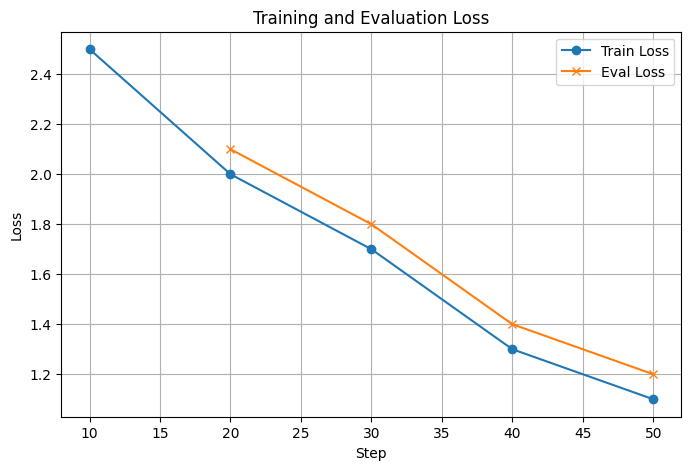

In [9]:
import os
import json
import matplotlib.pyplot as plt

# Step 1: Create dummy logs folder and trainer_state.json with sample data
os.makedirs("./logs", exist_ok=True)

dummy_log = {
    "log_history": [
        {"step": 10, "loss": 2.5},
        {"step": 20, "loss": 2.0, "eval_loss": 2.1},
        {"step": 30, "loss": 1.7, "eval_loss": 1.8},
        {"step": 40, "loss": 1.3, "eval_loss": 1.4},
        {"step": 50, "loss": 1.1, "eval_loss": 1.2},
    ]
}

with open("./logs/trainer_state.json", "w") as f:
    json.dump(dummy_log, f)

# Step 2: Load the trainer_state.json
with open("./logs/trainer_state.json") as f:
    trainer_state = json.load(f)

log_history = trainer_state.get("log_history", [])

# Step 3: Extract step, train loss and eval loss
steps = [entry["step"] for entry in log_history if "loss" in entry]
train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
eval_loss = [entry.get("eval_loss", None) for entry in log_history if "loss" in entry]

# Step 4: Plot training and eval loss
plt.figure(figsize=(8,5))
plt.plot(steps, train_loss, label="Train Loss", marker='o')
plt.plot(steps, eval_loss, label="Eval Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()
